In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler


# Cruide Oil WTI

## 7:3

In [2]:
# Đọc dữ liệu
df = pd.read_csv('Crude Oil WTI Futures Historical Data.csv').dropna()

In [3]:
# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)
# Đảo ngược dữ liệu để dự đoán giá trị trong tương lai
df = df.iloc[::-1].reset_index(drop=True)


In [4]:
df.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-03-27,81.35,81.29,81.74,80.55,249.96K,-0.33%
1,2024-03-26,81.62,81.94,82.36,81.22,235.85K,-0.40%
2,2024-03-25,81.95,80.85,82.48,80.59,300.36K,1.64%
3,2024-03-22,80.63,80.84,81.45,80.42,231.10K,-0.54%
4,2024-03-21,81.07,81.49,81.92,80.30,266.86K,-0.75%


In [5]:

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str


def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df = df.iloc[::-1].reset_index(drop=True)

In [6]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-01-02,46.54,45.80,47.78,44.35,850480,1.42
1,2019-01-03,47.09,46.26,47.49,45.35,788720,1.18
2,2019-01-04,47.96,46.90,49.22,46.65,817280,1.85
3,2019-01-07,48.52,48.30,49.79,48.11,819940,1.17
4,2019-01-08,49.78,48.73,49.95,48.31,765980,2.60
...,...,...,...,...,...,...,...
1291,2024-03-21,81.07,81.49,81.92,80.30,266860,-0.75
1292,2024-03-22,80.63,80.84,81.45,80.42,231100,-0.54
1293,2024-03-25,81.95,80.85,82.48,80.59,300360,1.64
1294,2024-03-26,81.62,81.94,82.36,81.22,235850,-0.40


In [7]:
price = df['Price'].values
price = price.reshape(-1, 1)

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [9]:
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [10]:

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])



In [11]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [12]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform([Y_test])

In [13]:

def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 2.2107309512230655
MAPE trên tập test là: 2.1682569519625936 %
MAE trên tập test là: 1.7098929347826064


In [15]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-20:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat.reshape(-1,1), axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)



[[82.6414]
 [83.0695]
 [83.6948]
 [83.7583]
 [83.3713]
 [83.2759]
 [83.2197]
 [83.23  ]
 [83.2492]
 [83.114 ]
 [82.8501]
 [82.5768]
 [82.614 ]
 [82.7716]
 [82.9397]
 [82.9579]
 [82.8718]
 [82.8513]
 [82.8412]
 [82.6629]
 [82.6282]
 [82.6057]
 [82.7221]
 [82.7291]
 [82.67  ]
 [82.6858]
 [82.68  ]
 [82.713 ]
 [82.7126]
 [82.6939]]


In [16]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(df), len(df)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_30_days_df

,0
1296,82.6414
1297,83.0695
1298,83.6948
1299,83.7583
1300,83.3713
1301,83.2759
1302,83.2197
1303,83.2300
1304,83.2492
1305,83.1140


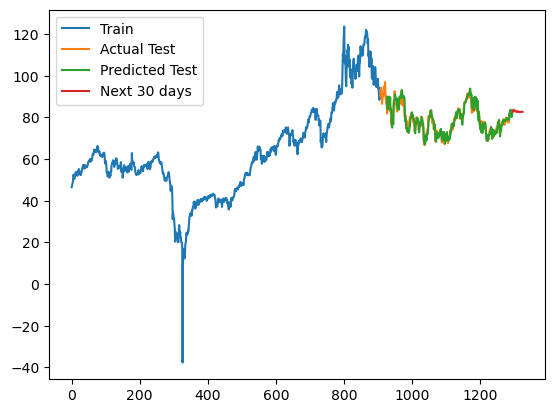

In [17]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')

plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.savefig('Cruide_Oil_73_Fix.png') 
plt.show()


## 8:2

In [18]:
train_size = int(len(price_scaled) * 0.8)
test_size = int(len(price_scaled) * 0.2)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [19]:

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])


In [20]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [21]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform([Y_test])

In [22]:

def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 1.5743936212537046
MAPE trên tập test là: 1.7017404432782677 %
MAE trên tập test là: 1.313082845188286


In [23]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-20:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat.reshape(-1,1), axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)


[[80.9469]
 [79.8728]
 [80.0774]
 [80.0449]
 [79.1709]
 [77.9996]
 [78.1021]
 [78.0663]
 [78.0774]
 [77.9218]
 [77.7559]
 [78.262 ]
 [78.4938]
 [78.0739]
 [78.5225]
 [78.429 ]
 [77.9082]
 [78.0825]
 [78.2314]
 [78.0913]
 [78.2824]
 [78.3702]
 [78.187 ]
 [78.3985]
 [77.8968]
 [78.0846]
 [78.4219]
 [77.7991]
 [78.0294]
 [78.3457]]


In [24]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(df), len(df)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_30_days_df

,0
1296,80.9469
1297,79.8728
1298,80.0774
1299,80.0449
1300,79.1709
1301,77.9996
1302,78.1021
1303,78.0663
1304,78.0774
1305,77.9218


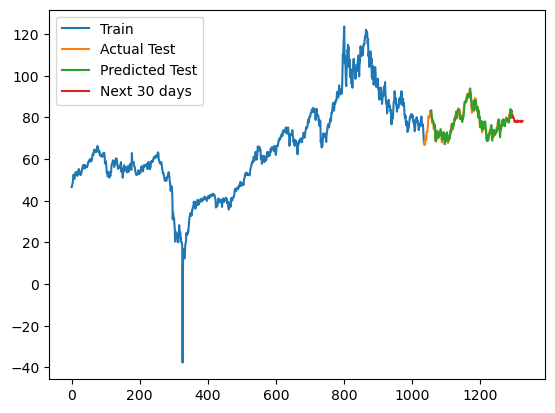

In [25]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')

plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()

### 9:1

In [26]:
train_size = int(len(price_scaled) * 0.9)
test_size = int(len(price_scaled) * 0.1)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [27]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [28]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [29]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform([Y_test])

In [30]:

def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 1.6341607645527716
MAPE trên tập test là: 1.7464661594659112 %
MAE trên tập test là: 1.3372000000000033


In [31]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-20:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat.reshape(-1,1), axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)


[[80.9082]
 [79.8951]
 [80.3091]
 [79.9381]
 [79.5847]
 [79.8781]
 [80.1657]
 [80.6968]
 [80.5846]
 [80.5023]
 [80.3401]
 [80.2993]
 [80.3744]
 [80.3009]
 [80.3287]
 [80.2221]
 [80.2681]
 [80.2245]
 [80.2162]
 [80.2207]
 [80.2371]
 [80.2247]
 [80.2168]
 [80.2993]
 [80.2481]
 [80.142 ]
 [80.1751]
 [80.1979]
 [80.1915]
 [80.2199]]


In [32]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(df), len(df)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_30_days_df

,0
1296,80.9082
1297,79.8951
1298,80.3091
1299,79.9381
1300,79.5847
1301,79.8781
1302,80.1657
1303,80.6968
1304,80.5846
1305,80.5023


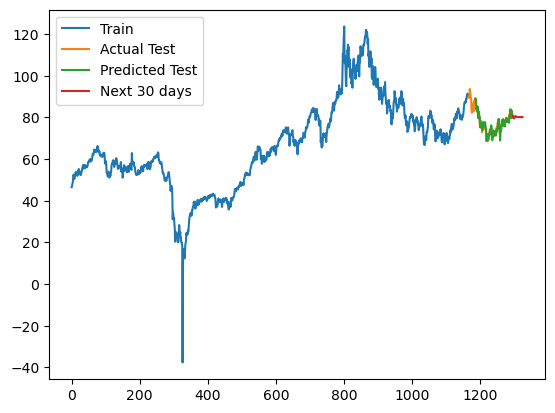

In [33]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')

plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()